# Pump it Up: Data Mining the Water Table

The goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint


## Antes de empezar
1. Estamos ante un problema de clasification. Podemos provar modelos tan variados como: logisticregression (classification), SVM (linear, rbf, ..), random forests, XGB model, e incluso con algun modelo de NN (Deep Learning).
2. Lo primero será mirar con calma la variable a predecir: categorica
3. Miraremos al detalle todas las features: numericas y categoricas
4. missing data, transformar datos (¿log?), estandarizamos (min-max, normalizar,..)
5. primer modelo de referencia: probamos con un SVM lineal y uno de rbf para ver si estamos ant modelo lineal o no.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
plots_show=0

## 1. Explore the target
The labels in this dataset are simple. There are three possible values:

- `functional` - the waterpoint is operational and there are no repairs needed
- `functional needs repair` - the waterpoint is operational, but needs repairs
- `non functional` - the waterpoint is not operational

In [3]:
df_train = pd.read_csv('files/train.csv')
df_test = pd.read_csv('files/test.csv')
target= pd.read_csv('files/labels.csv')

# CONCAT THE TWO DATAFRAMES
df_train = pd.concat([df_train,target],axis=1)

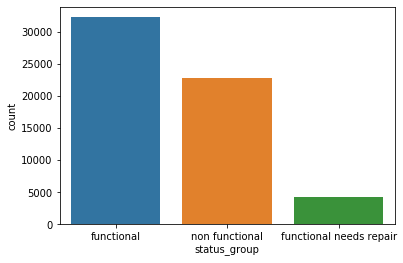

In [4]:
sns.countplot(data=df_train, x = 'status_group')

Bien, en este sentido los datos no estan bien balanceados. Esto es logico, ya que lo esperado es que la mayoria son funcionales, luego tenemos algunos que no funcionan y finalmente un grupo más pequeño de sistemas que funcionan, pero necesitan reparaciones...
Habrá que tener en cuenta esto en los modelos...

## 2. Exploramos los datos de entrenamiento

In [5]:
df_train.columns
df_train.drop(columns=['id'],inplace=True)
df_test.drop(columns=['id'],inplace=True)

In [6]:
df_train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [7]:
df_train.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [8]:
null_columns = df_train.columns[df_train.isnull().any()].tolist()
df_train[null_columns].isnull().sum()

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

Miramos si hay duplicados y los eliminamos....

In [9]:
print( 'duplicated data :',df_train[df_train.duplicated(keep=False)].sort_values(by='wpt_name').shape)

duplicated data : (70, 40)


In [10]:
df_train.drop_duplicates(keep='first', inplace=True)
print ('final shape df_train: ', df_train.shape)

final shape df_train:  (59364, 40)


En este punto me surgen varias dudas:
1. Tenemos datos por punto de bombeo una sola vez? O hay varios registros por punto de bombeo?
2. Podrian haber filas duplicadas pero con algun error en algun valor?
3. Podria haber filas duplicadas pero con target diferente?

Hay que mirar esto con calma para acabar de limpiar datos...
El problema principal es que no tenemos niguna columna, a priori, que nos pueda servir para identificar puntos de bombeo

Miramos las `num_private` y `wpt_name`....

In [11]:
print('Duplicated num_private values :',
      df_train['num_private'].dropna().loc[df_train['num_private'].duplicated()].count())
print('Duplicated wpt_name names :',
      df_train['wpt_name'].dropna().loc[df_train['wpt_name'].duplicated()].count())

Duplicated num_private values : 59299
Duplicated wpt_name names : 21964


`num_private` parece que tiene el 99% de los datos repetidos. Habrá que considerar eliminar esta feature.  
`wpt_name`tiene casi la mitad de los nombres repetidos.

Niguna de estas dos nos puede servir.

Vamos a usar el numero máximo de variables que se puedan considerar únicas de cada punto de muestreo para ver si hay más errores de registros.

In [12]:
df_kk = df_train[df_train.duplicated(subset=['funder','installer','longitude','latitude','wpt_name',
                                             'basin','subvillage','region','region_code','lga',
                                             'scheme_management','scheme_name','extraction_type',
                                             'extraction_type_group','permit','extraction_type_class',
                                            'source','installer','source_type','source_class',
                                             'waterpoint_type_group','waterpoint_type','district_code',
                                             'ward','quantity_group','quantity','quality_group'],keep=False)]

print ('Shape of dataframe with duplicated rows: ',df_kk.shape)

Shape of dataframe with duplicated rows:  (90, 40)


Estas las vamos a mirar a mano. (Una a una)

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_kk.sort_values(by='longitude').tail(5)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
56544,0.0,2011-03-27,W.D & I.,562,RWE,37.542785,-6.965834,Kwa Kitula Mbenge,0,Wami / Ruvu,Gudugudu,Morogoro,5,6,Mvomero,Mlali,1,True,GeoData Consultants Ltd,VWC,Mongwa r,True,1960,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional
43089,0.0,2011-03-27,W.D & I.,567,RWE,37.543351,-6.963557,Kwa Leha,0,Wami / Ruvu,Gudugudu,Morogoro,5,6,Mvomero,Mlali,90,True,GeoData Consultants Ltd,VWC,Mongwa r,True,1968,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional needs repair
48859,0.0,2011-03-24,W.D & I.,567,RWE,37.543351,-6.963557,Kwa Leha,0,Wami / Ruvu,Gudugudu,Morogoro,5,6,Mvomero,Mlali,90,True,GeoData Consultants Ltd,VWC,Mongwa r,True,1968,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional needs repair
51584,0.0,2011-03-24,Government Of Tanzania,568,RWE,37.543401,-6.958716,Kwa Veremond Kunambi,0,Wami / Ruvu,Majengo,Morogoro,5,6,Mvomero,Mlali,1,True,GeoData Consultants Ltd,VWC,Mongwa r,True,1974,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional
17294,0.0,2011-03-27,Government Of Tanzania,568,RWE,37.543401,-6.958716,Kwa Veremond Kunambi,0,Wami / Ruvu,Majengo,Morogoro,5,6,Mvomero,Mlali,1,True,GeoData Consultants Ltd,VWC,Mongwa r,True,1974,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional


- index **56599 and 2422** shows same registered data (all equal) but different target (functional and functional needs repair). We will drop both.. 

- index 17210 and **51478** in this case we have 2 registers different days with different targets: one 2011-08-05 (functional needs repair) and 2013-01-28(no functional) --> ¿utilizamos los dos? o solo uno? Si queremos los dos, hay que ver como consideramos las fechas.....**por ahora eliminaremos el primero, y dejaremos el no functional, pero habrá que mirar si las fechas son importantes**

- index 35306 and 30708 shows the same data, but 30708 have information more accurated for som columns (amount_tsh, gps_height, ...). The **35306** should be droped.

- index 43948 and 38346. More info in 38346, **43948** should be droped

- in. 44676 and 47145. **47145** should be dropped

- in. 9129 and 8057. **8057** should be dropped.

- in. 2457 and **48946**

- few more rows like previous ones....we should drop: **9283, 58561,  44079, 23856, 58190, 54551, 29596, 42876, 46455, 2401, 31851, 35674, 11895, 42163, 30622, 4125,**

- in. 29367 and 19866 (same for 50330-50232, 51319-29640, 50878-48361, 13570-29872, 30760-8896, 24983-28701, 37766-17442, 51672-50694, 38604-7560, 2287-10267, 41601-50543, 15917-57824, 6775-8979, 11121-13864, 24995-24029, 41398-27569, 57423-9187, 8630-6516, 37198-56544, 43089-48859, 51584-17294   have same data for all rows (only variation is for date -1 week of difference-, so we drop one of them). **19866, 50232, 29640, 48361,  29872, 8896, 28701, 17442, 50694, 7560, 10267, 50543, 57824, 8979, 13864, 24029, 27569, 9187, 6516, 37198, 48859 and 17294**

In [14]:
df_train.drop([56599, 2422, 51478, 35306,43948,47145,8057,48946,9283,58561,44079,23856,58160,54551,
                     29596,42876,46455,2401,31851,35674,11895,42163,30622,4125,19866,50232, 29640,
                     48361,29872,8896,28701,17442,50694,7560,10267,50543,8979,13864,24029,27569,9187,
                     6516,37198,48859,17294], inplace=True)

In [15]:
df_train.shape

(59319, 40)

In [16]:
df_train.head(5)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Analisis de las variables (una a una)

### <font color='green'> Variables a eliminar </font>

Algunas variables a eliminar (a priori):
1. latitud y longitud: sirven para identificar puntos únicos y posibles duplicados, pero como variable no veo que pueda servir. **Drop `latitude` and `longitude`**
2. `num_private` parece que tenemos muy pocos datos (lo volvemos a mirar y si hay muy poco lo podemos eliminar.
3. `region` and `region_code` are the same? si son lo mismo eliminamos una de ellas no? --> NO lo son!
4. lo mismo para `lga` y `district_code` --> NO lo son
5. lo mismo para `extraction_type` and `extraction_type_group` --> NO, son diferentes
6. lo mismo para `payment` and `payment_type` --> **SI, son iguales. Drop `payment_type`**
7. ¿lo mismo para `management` and `management_group`? --> No. No eliminamos ninguno porque uno de ellos es agrupaciones del otro, y esto puede dar información util.
8. ¿`water_quality` and `quality_group`? --> No. Idem.
9. ¿`quantity` and `quantity_group`? --> No. Idem.
10. ¿`source` and `source_type`? --> No. Idem.

In [17]:
# example of payment and payment_type. The information is repeated.
df_train[['payment','payment_type']].groupby(by='payment_type').nunique()

,payment,payment_type
payment_type,,
annually,1,1
monthly,1,1
never pay,1,1
on failure,1,1
other,1,1
per bucket,1,1
unknown,1,1


In [18]:
# example of management and management_group. The information is in this case is not repeated and we can not delete it.
df_train[['management','management_group']].groupby(by='management_group').nunique()

,management,management_group
management_group,,
commercial,4,1
other,2,1
parastatal,1,1
unknown,1,1
user-group,4,1


### <font color='orange'> drop data 1/? </font>

In [19]:
df_train.drop(columns=['latitude','longitude','payment_type'],inplace=True)
df_test.drop(columns=['latitude','longitude','payment_type'],inplace=True)

## <font color='green'> Recorded dates </font>
Podria ser que la fecha tuviese alguna relacion con la clasificacion? lo ideal seria que no....pero no acabo de estar seguro (por ejemplo: y si a lo largo de los años han cambiado de criterio, y lo que en algun momento era need_repararation luego pasó a non_functional? (con las mismas caracterixticas?)

In [20]:
df_train['date']=pd.to_datetime(df_train['date_recorded'])
df_test['date']=pd.to_datetime(df_test['date_recorded'])

 ######### Train data ##########
number of different date_recorded:  356
first date of date_recorded:  2002-10-14 00:00:00
last date of date_recorded:  2013-12-03 00:00:00
 
######### Test data ##########
number of different date_recorded:  331
first date of date_recorded:  2001-03-26 00:00:00
last date of date_recorded:  2013-12-03 00:00:00


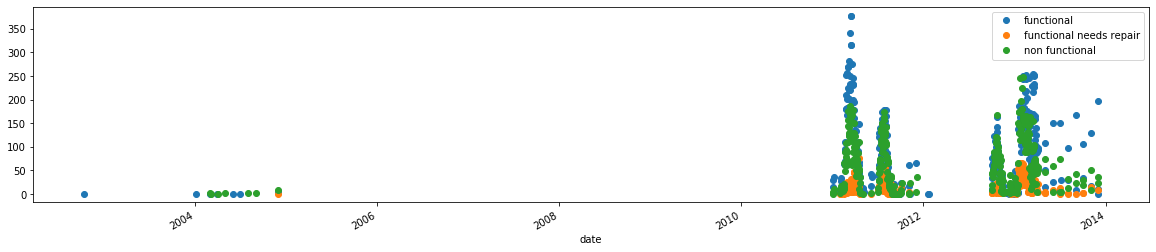

In [21]:
#Dates train
print (' ######### Train data ##########')
print ('number of different date_recorded: ',df_train['date'].nunique() )
print( 'first date of date_recorded: ', df_train['date'].min())
print( 'last date of date_recorded: ', df_train['date'].max())

#Dates Test
print (' \n######### Test data ##########')
print ('number of different date_recorded: ',df_test['date'].nunique() )
print( 'first date of date_recorded: ', df_test['date'].min())
print( 'last date of date_recorded: ', df_test['date'].max())

# PLOT
fig= plt.figure(figsize=(20,4))
df_train[df_train['status_group']=='functional'].groupby('date')['status_group'].count().plot(style='o')
df_train[df_train['status_group']=='functional needs repair'].groupby('date')['status_group'].count().plot(style='o')
df_train[df_train['status_group']=='non functional'].groupby('date')['status_group'].count().plot(style='o')
plt.legend(('functional', 'functional needs repair', 'non functional') )
plt.show()

Parece que para el training set tenemos la mayoria de los datos con fechas entre 2011 y final 2013. Aun así, tenemos datos de 2001 hasta 2005 (muy pocos). 

In [22]:
print ('samples recordee before 2010 in the training set: ',df_train[df_train['date']<'2010-01-01'].shape)
print ('samples recordee since 2010 in the training set: ',df_train[df_train['date']>'2010-01-01'].shape)
print(' ---------------------------------------------------')
print ('samples recordee before 2010 in the test set: ',df_test[df_test['date']<'2006-01-01'].shape)
print ('samples recordee before 2010 in the training set: ',df_test[df_test['date']>'2010-01-01'].shape)

samples recordee before 2010 in the training set:  (31, 38)
samples recordee since 2010 in the training set:  (59288, 38)
 ---------------------------------------------------
samples recordee before 2010 in the test set:  (12, 37)
samples recordee before 2010 in the training set:  (14838, 37)


Aqui ahora tenemos dudas de que hacer:
1. ¿eliminar en training set datos anteriores a 2010 y eliminar columna fechas? --> se podrian considerar outliers con metodologias de muestreo obsoletas (pero en el test set hay 12 de este periodo...)
2. Crear columnas año (serian unas 5-6), y columnas mes de muestreo (12). 

<font color='blue'> Por ahora probaremos opción 1. Eliminamos datos previos a 2010 y hacemos un drop de la columna date_recorded y date </font>

### <font color='orange'> drop data 2/? </font>

In [23]:
# only for train data
df_train = df_train[df_train['date']>'2010-01-01']

# both train and test drop date columns
df_train.drop(columns=['date','date_recorded'],inplace=True)
df_test.drop(columns=['date','date_recorded'],inplace=True)

In [24]:
df_train.head(5)

,amount_tsh,funder,gps_height,installer,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,Roman,1390,Roman,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,Grumeti,1399,GRUMETI,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,Lottery Club,686,World vision,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,Unicef,263,UNICEF,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,Action In A,0,Artisan,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## <font color='green'> Amount of water </font>

In [25]:
# first count how many 0 do we have
print ('Amount of 0: ',df_train[df_train.amount_tsh == 0].shape[0])
print ('Percentage of 0 respect the total: ',df_train[df_train.amount_tsh == 0].shape[0]/df_train.shape[0]*100)

Amount of 0:  41531
Percentage of 0 respect the total:  70.04958844960194


Esto indica que solo un 30% de los datos muestra valores de agua disponible...pero seguro que hay puntos que funcionan pero con 0 aqui....
Parece que hay mas, en terminos relativos, puntos que no funcionan respecto del total

**este punto es dificil de imputar datos o mejrar, ya que a priori no se ve una relacion directa con otra variable**

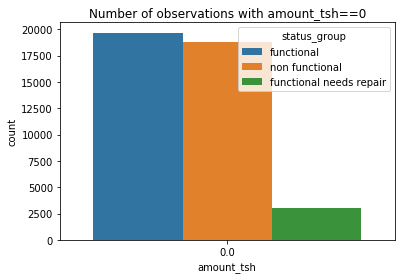

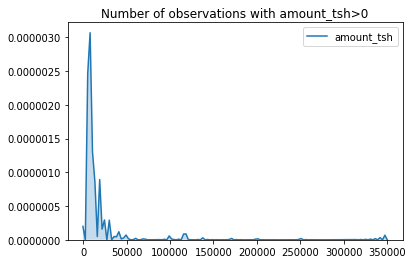

In [26]:
df_k=df_train[df_train.amount_tsh==0]
sns.countplot(data=df_k,x='amount_tsh',hue='status_group')
plt.title('Number of observations with amount_tsh==0')
plt.show()


df_k=df_train[df_train.amount_tsh!=0]
sns.kdeplot(data=df_k.amount_tsh,shade=True)
plt.title('Number of observations with amount_tsh>0')
plt.show()

## <font color='green'> gps_height </font>

In [27]:
# first count how many 0 do we have
print ('Amount of 0: ',df_train[df_train.gps_height == 0].shape[0])
print ('Percentage of 0 respect the total: ',df_train[df_train.gps_height == 0].shape[0]/df_train.shape[0]*100)

Amount of 0:  20367
Percentage of 0 respect the total:  34.35265146403994


Esto indica que solo un 65% de los datos muestra valores altura...no acabo de ver si esta vraiable nos sirve o no

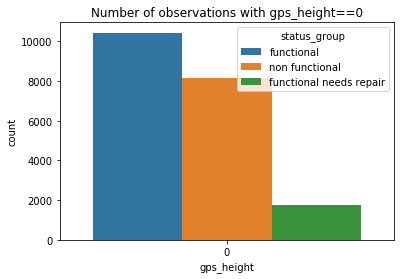

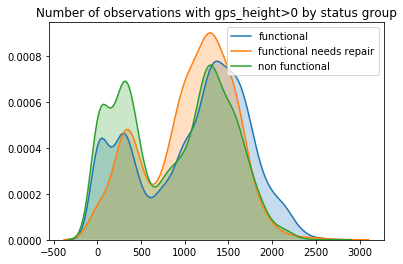

In [28]:
df_k=df_train[df_train.gps_height==0]
sns.countplot(data=df_k,x='gps_height',hue='status_group')
plt.title('Number of observations with gps_height==0')
plt.show()

#---
df_k=df_train[(df_train.gps_height!=0) & (df_train.status_group=='functional')]
sns.kdeplot(data=df_k.gps_height,shade=True)

df_k=df_train[(df_train.gps_height!=0) & (df_train.status_group=='functional needs repair')]
sns.kdeplot(data=df_k.gps_height,shade=True)

df_k=df_train[(df_train.gps_height!=0) & (df_train.status_group=='non functional')]
sns.kdeplot(data=df_k.gps_height,shade=True)
plt.title('Number of observations with gps_height>0 by status group')
plt.legend(['functional','functional needs repair','non functional'])
plt.show()

Parece que esta variable puede servir para discrminiar entre status_groups, ya que muestra dsitribuciones diferentes...

## <font color='green'> num_private </font>

In [29]:
# first count how many 0 do we have
print ('Amount of 0: ',df_train[df_train.num_private == 0].shape[0])
print ('Percentage of 0 respect the total: ',df_train[df_train.num_private == 0].shape[0]/df_train.shape[0]*100)

Amount of 0:  58531
Percentage of 0 respect the total:  98.72318175684794


Esta variable esta en 0 el 99% de los casos. Aun asi, miramos la distribucion de los 0 y de los que no..no sea que identifique uno de los status

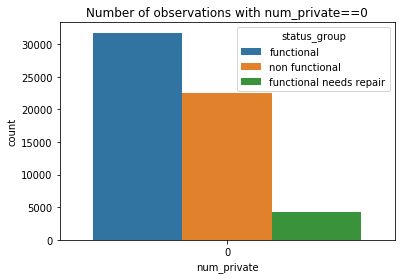

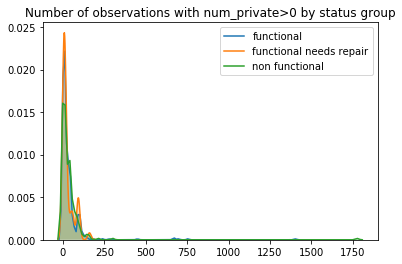

In [30]:
df_k=df_train[df_train.num_private==0]
sns.countplot(data=df_k,x='num_private',hue='status_group')
plt.title('Number of observations with num_private==0')
plt.show()

#---
df_k=df_train[(df_train.num_private!=0) & (df_train.status_group=='functional')]
sns.kdeplot(data=df_k.num_private,shade=True)

df_k=df_train[(df_train.num_private!=0) & (df_train.status_group=='functional needs repair')]
sns.kdeplot(data=df_k.num_private,shade=True)

df_k=df_train[(df_train.num_private!=0) & (df_train.status_group=='non functional')]
sns.kdeplot(data=df_k.num_private,shade=True)
plt.title('Number of observations with num_private>0 by status group')
plt.legend(['functional','functional needs repair','non functional'])
plt.show()

Parece que esta variable no muestra distribuciones diferentes segun el status_group, así, que ya que no muestra diferencias y solo tiene 1000 valores diferentes de 0, la eliminamos!  

### <font color='orange'> drop data 3/? </font>

In [31]:
df_train.drop(columns=['num_private'],inplace=True)
df_test.drop(columns=['num_private'],inplace=True)

## <font color='green'> Population </font>

In [32]:
# first count how many 0 do we have
print ('Amount of 0: ',df_train[df_train.population == 0].shape[0])
print ('Percentage of 0 respect the total: ',df_train[df_train.population == 0].shape[0]/df_train.shape[0]*100)

Amount of 0:  21310
Percentage of 0 respect the total:  35.94319255161247


En este caso tenemos bastantes datos de poblacion....quizas podemos rellenar los 0 con algun metodo de imputacion

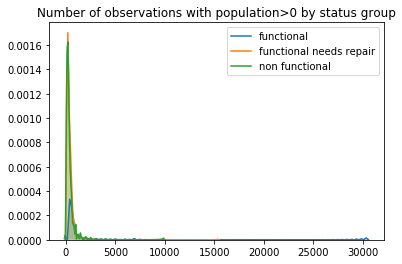

In [33]:
#---
df_k=df_train[(df_train.population!=0) & (df_train.status_group=='functional')]
sns.kdeplot(data=df_k.population,shade=True)

df_k=df_train[(df_train.population!=0) & (df_train.status_group=='functional needs repair')]
sns.kdeplot(data=df_k.population,shade=True)

df_k=df_train[(df_train.population!=0) & (df_train.status_group=='non functional')]
sns.kdeplot(data=df_k.population,shade=True)
plt.title('Number of observations with population>0 by status group')
plt.legend(['functional','functional needs repair','non functional'])
plt.show()

Se trata de variable de poblacion. Lo que haremos sera imputar los 0 a partir de datos geolocalizacion:
1. subvillage
2. lga (district)

In [34]:
# 0 to NaNs
df_train['population'].replace(to_replace=0,value=np.nan,inplace=True)
df_test['population'].replace(to_replace=0,value=np.nan,inplace=True)

# impute Nans with subvillage > lga > region untill > all data no nans in the data
df_train['population'] = df_train['population'].fillna(df_train.groupby('subvillage')['population'].transform('mean'))
df_test['population'] = df_test['population'].fillna(df_train.groupby('subvillage')['population'].transform('mean'))
print ('\n train nans...',df_train.population.isnull().sum())
print ('test nans...',df_test.population.isnull().sum())

df_train['population'] = df_train['population'].fillna(df_train.groupby('lga')['population'].transform('mean'))
df_test['population'] = df_test['population'].fillna(df_train.groupby('lga')['population'].transform('mean'))
print ('\n train nans...',df_train.population.isnull().sum())
print ('test nans...',df_test.population.isnull().sum())

df_train['population'] = df_train['population'].fillna(df_train.groupby('region')['population'].transform('mean'))
df_test['population'] = df_test['population'].fillna(df_train.groupby('region')['population'].transform('mean'))
print ('\n train nans...',df_train.population.isnull().sum())
print ('test nans...',df_test.population.isnull().sum())

df_test['population'] = df_test['population'].fillna(df_train['population'].mean())
print ('\n train nans...',df_train.population.isnull().sum())
print ('test nans...',df_test.population.isnull().sum())


 train nans... 16413
test nans... 1471

 train nans... 450
test nans... 48

 train nans... 0
test nans... 7

 train nans... 0
test nans... 0


Esta variable por ahora la dejamos, pero no acabo de ver claro que discrimine suficiente...

## <font color='green'> construction_year </font>

Amount of 0:  20636
Percentage of 0 respect the total:  34.80636891107813


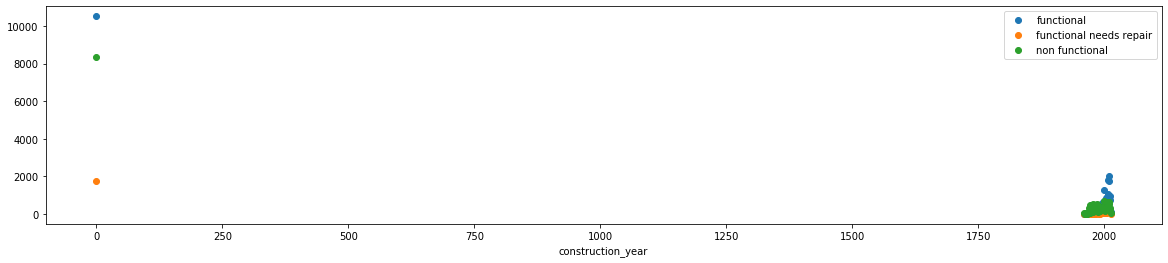

In [35]:
# first count how many 0 do we have
print ('Amount of 0: ',df_train[df_train.construction_year == 0].shape[0])
print ('Percentage of 0 respect the total: ',df_train[df_train.construction_year == 0].shape[0]/df_train.shape[0]*100)

# PLOT
fig= plt.figure(figsize=(20,4))
df_train[df_train['status_group']=='functional'].groupby('construction_year')['status_group'].count().plot(style='o')
df_train[df_train['status_group']=='functional needs repair'].groupby('construction_year')['status_group'].count().plot(style='o')
df_train[df_train['status_group']=='non functional'].groupby('construction_year')['status_group'].count().plot(style='o')
plt.legend(('functional', 'functional needs repair', 'non functional') )
plt.show()

Podemos provar de imputar datos a lo bestia: año medio, o por ejemplo imputarlo teniendo en cuenta la organizacion que los instaló (muchas veces estas organizaciones funcionan por planes o proyectos, por lo que podria ser una buena forma de hacerlo).

In [36]:
# 0 to NaNs
df_train['construction_year'].replace(to_replace=0,value=np.nan,inplace=True)
df_test['construction_year'].replace(to_replace=0,value=np.nan,inplace=True)
print ('initial nans...',df_train.construction_year.isnull().sum())

initial nans... 20636


In [37]:
# impute Nans funder that installed teh well: funder > installer > mean rest
df_train['construction_year'] = df_train['construction_year'].fillna(df_train.groupby('funder')['construction_year'].transform('mean'))
df_test['construction_year'] = df_test['construction_year'].fillna(df_train.groupby('funder')['construction_year'].transform('mean'))
print ('nans...',df_train.construction_year.isnull().sum())

df_train['construction_year'] = df_train['construction_year'].fillna(df_train.groupby('installer')['construction_year'].transform('mean'))
df_test['construction_year'] = df_test['construction_year'].fillna(df_train.groupby('installer')['construction_year'].transform('mean'))
print ('nans...',df_train.construction_year.isnull().sum())
df_train['construction_year'] = df_train['construction_year'].fillna(df_train['construction_year'].mean())
df_test['construction_year'] = df_test['construction_year'].fillna(df_train['construction_year'].mean())
print ('nans...',df_train.construction_year.isnull().sum())

nans... 7464
nans... 3859
nans... 0


In [38]:
# now we can convert thos to age of the well, and the binarize the data
df_train['age_well']=abs(df_train.construction_year - df_train.construction_year.max() +1)
df_test['age_well']=abs(df_test.construction_year - df_train.construction_year.max() +1)

df_train['age_well_bin']=pd.cut(df_train['age_well'], 
                                bins=[-1,4,9,14,19,24,29,35,39,44,49,54], 
                                labels=['0','5','10','15','20','25','30','35','40','45','50'])

df_test['age_well_bin']=pd.cut(df_test['age_well'], 
                                bins=[-1,4,9,14,19,24,29,35,39,44,49,54], 
                                labels=['0','5','10','15','20','25','30','35','40','45','50'])

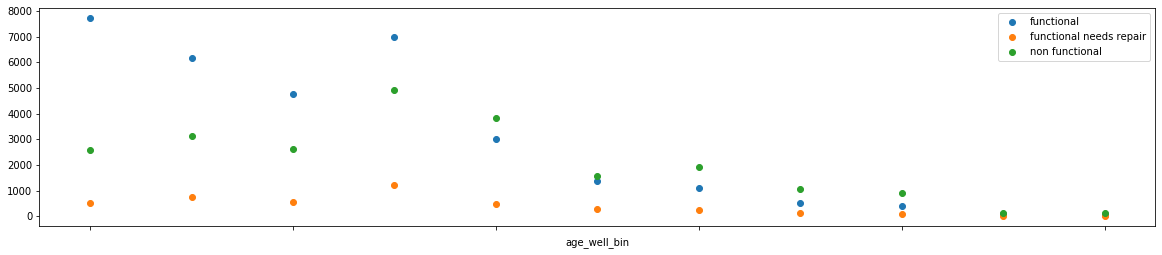

In [39]:
fig= plt.figure(figsize=(20,4))
df_train[df_train['status_group']=='functional'].groupby('age_well_bin')['status_group'].count().plot(style='o')
df_train[df_train['status_group']=='functional needs repair'].groupby('age_well_bin')['status_group'].count().plot(style='o')
df_train[df_train['status_group']=='non functional'].groupby('age_well_bin')['status_group'].count().plot(style='o')
plt.legend(('functional', 'functional needs repair', 'non functional') )
plt.show()

In [40]:
df_train.drop(columns=['construction_year','age_well'],inplace=True)
df_test.drop(columns=['construction_year','age_well'],inplace=True)

## <font color='green'> CATEGORICAL FEATURES </font>

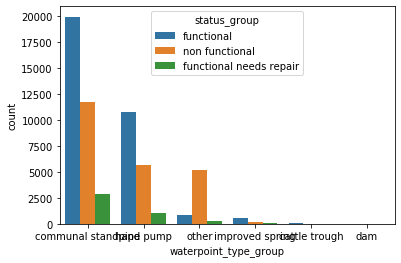

In [41]:
sns.countplot(data=df_train, x='waterpoint_type_group', hue='status_group')

In [42]:
# FUNCTION TO PLOT BOX-PLOT o SCATTERPLOT
def plot_boxplot(n,m,df,figx,figy,y_val,box=1):
    """This function plot a multple subplot (defined by n & m) for a dataframe, also defining the size of the figure.
    The plot could be boxplot (box=1) for categorical data, and regplot for numerical data"""
    fig, axs = plt.subplots(n,m,figsize=(figx,figy))
    rect = fig.patch
    rect.set_facecolor('white')
    axs = axs.flatten()
    
    ll= df.columns.to_list()
    ll.remove(y_val)

    for i,(ax, feature) in enumerate (zip(axs, ll)):
        boxplot = sns.countplot(data=df, x=feature, hue='status_group',ax=ax)
                    
        boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')
        #boxplot.legend()
    plt.tight_layout()

In [74]:
# CATEGOTICAL FEATURES TRAIN
cat_feats = df_train.dtypes[df_train.dtypes == "object"].index
df_train[cat_feats].nunique()

basin                      9
region                    21
lga                      125
public_meeting             3
scheme_management         12
permit                     3
extraction_type           18
extraction_type_group     13
extraction_type_class      7
management                12
management_group           5
payment                    7
water_quality              8
quality_group              6
quantity                   5
quantity_group             5
source                    10
source_type                7
source_class               3
waterpoint_type            7
waterpoint_type_group      6
status_group               3
dtype: int64

In [73]:
# CATEGOTICAL FEATURES TEST
cat_feats_test = df_test.dtypes[df_test.dtypes == "object"].index
df_test[cat_feats_test].nunique()

basin                      9
region                    21
lga                      125
public_meeting             3
scheme_management         11
permit                     3
extraction_type           17
extraction_type_group     13
extraction_type_class      7
management                12
management_group           5
payment                    7
water_quality              8
quality_group              6
quantity                   5
quantity_group             5
source                    10
source_type                7
source_class               3
waterpoint_type            7
waterpoint_type_group      6
dtype: int64

Hay algunas variables categoricas con muchos valores (wpt_name con >30000, ward=2092, ....).
Las eliminamos en este primer analisis para simplificar, mas adelante vemos si nos interesa mantenerlas....

además, `recorded_by` solo tiene un grupo....no aporta informacion

### <font color='orange'> drop data 4/? </font>

In [44]:
df_train.drop(columns=['recorded_by'],inplace=True)
df_test.drop(columns=['recorded_by'],inplace=True)

In [45]:
df_train.drop(columns=['funder','installer','wpt_name','subvillage','ward','scheme_name'],inplace=True)
df_test.drop(columns=['funder','installer','wpt_name','subvillage','ward','scheme_name'],inplace=True)

In [46]:
cat_feats = df_train.dtypes[df_train.dtypes == "object"].index
# PLOT SCATTERPLOT with REGRESSION LINE
if plots_show==1:plot_boxplot(7,3,df_train[cat_feats],15,30,'status_group',box=0)

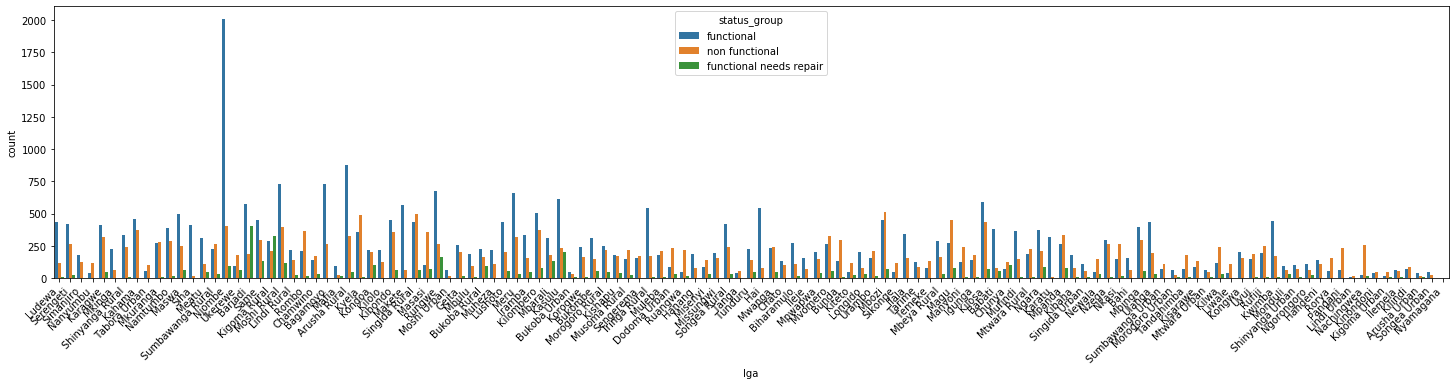

In [47]:
fig = plt.figure(figsize=(25,5))
boxplot = sns.countplot(data=df_train, x='lga', hue='status_group')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

# Pre-proceso
0. Faltan nans por rellenar?
1. get-dummies de las categoricas
2. escalado (min-max) del resto
3. ¿ no hemos hecho niguna transformacion logaritmica de las variables...quizas...?

## <font color='green'> Missing NaNs </font>

In [48]:
null_columns = df_train.columns[df_train.isnull().any()].tolist()
print ('Nans in train set: \n',df_train[null_columns].isnull().sum() )
null_columns = df_test.columns[df_test.isnull().any()].tolist()
print ('\nNans in test set: \n',df_test[null_columns].isnull().sum() )

Nans in train set: 
 public_meeting       3306
scheme_management    3873
permit               3055
dtype: int64

Nans in test set: 
 public_meeting       821
scheme_management    969
permit               737
dtype: int64


#### public_meeting

In [49]:
print('public_meeting total: ',df_train.public_meeting.shape[0])
print('public_meeting Trues: ',df_train.public_meeting.sum())
print('public_meeting False:  ',df_train.public_meeting.shape[0] - df_train.public_meeting.sum() -df_train.public_meeting.isnull().sum())
print('public_meeting NaNs :  ',df_train.public_meeting.isnull().sum() )

public_meeting total:  59288
public_meeting Trues:  50937
public_meeting False:   5045
public_meeting NaNs :   3306


Aproximadamente tenemos un 86% de datos True, y un 8% de False. Imputando los nans aqui con el mas repetido no me acaba de gustar. Crearemos un grupo nuevo: 'Unknown'.

In [50]:
df_train['public_meeting'].fillna(value='Unknown',inplace=True)
df_test['public_meeting'].fillna(value='Unknown',inplace=True)

#### scheme_management
In this feature there is already a group called 'Other'. We will imput all the missing data to this group.

In [51]:
df_train['scheme_management'].fillna(value='Other',inplace=True)
df_test['scheme_management'].fillna(value='Other',inplace=True)

#### permit

In [52]:
print('permit total: ',df_train.permit.shape[0])
print('permit Trues: ',df_train.permit.sum())
print('permit False:  ',df_train.permit.shape[0] - df_train.permit.sum() -df_train.permit.isnull().sum())
print('permit NaNs :  ',df_train.permit.isnull().sum() )

permit total:  59288
permit Trues:  38778
permit False:   17455
permit NaNs :   3055


Muy parecido a public_meeting. Tenemos un 70% de datos True, y un 25% de False. Imputando los nans aqui con el mas repetido no me acaba de gustar. Crearemos un grupo nuevo: 'Unknown'.

In [53]:
df_train['permit'].fillna(value='Unknown',inplace=True)
df_test['permit'].fillna(value='Unknown',inplace=True)

## <font color='green'> Get Dummies </font>

In [54]:
# Categorical data to Dummy
cat_feats = df_train.dtypes[df_train.dtypes == "object"].index
cat_feats_test = df_test.dtypes[df_test.dtypes == "object"].index

In [70]:
cat_feats

Index(['basin', 'region', 'lga', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [71]:
cat_feats_test

Index(['basin', 'region', 'lga', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [56]:
pd.set_option('display.max_columns', 500)
df_train[cat_feats].head()

,basin,region,lga,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,Lake Nyasa,Iringa,Ludewa,True,VWC,False,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,Lake Victoria,Mara,Serengeti,Unknown,Other,True,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,Pangani,Manyara,Simanjiro,True,VWC,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,Ruvuma / Southern Coast,Mtwara,Nanyumbu,True,VWC,True,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,Lake Victoria,Kagera,Karagwe,True,Other,True,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [67]:
df_cat_D = pd.get_dummies(df_train[cat_feats],dummy_na=False, drop_first=True)
df_cat_D_test = pd.get_dummies(df_test[cat_feats_test],dummy_na=False, drop_first=True)

df_cat_D.drop(columns=['status_group_functional needs repair', 'status_group_non functional'],inplace=True)

In [69]:
print (df_cat_D.shape)
print (df_cat_D_test.shape)

(59288, 271)
(14850, 269)


## <font color='red'> ens falta alguna feature al test!!!!!! te pinta que ha de ser algunas catgeires </font>

In [64]:
df_cat_D.columns

Index(['basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji',
       'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'region_Dar es Salaam', 'region_Dodoma',
       ...
       'waterpoint_type_hand pump', 'waterpoint_type_improved spring',
       'waterpoint_type_other', 'waterpoint_type_group_communal standpipe',
       'waterpoint_type_group_dam', 'waterpoint_type_group_hand pump',
       'waterpoint_type_group_improved spring', 'waterpoint_type_group_other',
       'status_group_functional needs repair', 'status_group_non functional'],
      dtype='object', length=273)

## <font color='green'> Standarization </font>

In [62]:
num_feats = df_train.dtypes[df_train.dtypes != "object"].index
num_feats_test = df_test.dtypes[df_test.dtypes != "object"].index

In [63]:
num_feats

Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'age_well_bin'],
      dtype='object')